<img src="https://raw.githubusercontent.com/NCAR/dask-tutorial/main/images/NCAR-contemp-logo-blue.png"
     width="750px"
     alt="NCAR logo"
     style="vertical-align:middle;margin:30px 0px"/>

# Dask Arrays

**ESDS Dask Tutorial | 06 February, 2023**  

Negin Sobhani, Brian Vanderwende, Deepak Cherian, Ben Kirk  
Computational & Information Systems Lab (CISL)  
[negins@ucar.edu](mailto:negins@ucar.edu), [vanderwb@ucar.edu](mailto:vanderwb@ucar.edu)


---------

### In this tutorial, you learn:

* What is a Dask Array?
* Basic concepts and features of Dask Arrays
* Working with Dask arrays

**Related Dask Array Documentation**

* [Dask Array documentation](https://docs.dask.org/en/latest/array.html)
* [Dask Array API](https://docs.dask.org/en/latest/array-api.html)
* [Dask Array examples](https://examples.dask.org/array.html)


## Dask Arrays
Dask Arrays are basically parallelized version of NumPy arrays for processing *larger-than-memory data sets*. 

<img src="https://docs.dask.org/en/stable/_images/dask-array.svg" width="500px" style="horizontal-align:middle"/>

*Image credit: Anaconda, Inc. and contributors*

Dask Array can be used as a drop-in replacement for NumPy arrays, with a similar API and support for a subset of NumPy functions.  

Dask effectively reduces the memory footprint of large array computations by dividing the arrays into smaller pieces (called **chunks**) that can fit into memory and stream the data from disk.

**Dask Arrays are lazy:** Unlike Numpy, operations on Dask arrays are not computed until you explicitly request them. 

<div class="alert alert-success" markdown="1">

<b>Lazy Evaluation: objects are evaluated just in time when the results are needed!</b> 

Lazy evaluation help us avoid having large pieces of memory resident on the workers and optimize the resource requirements.

</div>

Dask Arrays don't directly hold any data. Instead, they provide **a symbolic representation of the necessary computations** to generate the data. We will explain this more below.  



Let's start exploring Dask Arrays:

## Setup: Start a Dask Client
We will talk in-depth about Dask Cluster and Dask Clients later in this tutorial. Here we just created a local cluster and attached a client to it. 

In [1]:
from dask.distributed import Client

client = Client()
client

2023-02-05 04:50:35,773 - distributed.diskutils - INFO - Found stale lock file and directory '/glade/scratch/negins/dask-worker-space/worker-bg_qbe63', purging
2023-02-05 04:50:35,774 - distributed.diskutils - INFO - Found stale lock file and directory '/glade/scratch/negins/dask-worker-space/worker-ho0r8zk1', purging
2023-02-05 04:50:35,774 - distributed.diskutils - INFO - Found stale lock file and directory '/glade/scratch/negins/dask-worker-space/worker-kxd0lb09', purging
2023-02-05 04:50:35,775 - distributed.diskutils - INFO - Found stale lock file and directory '/glade/scratch/negins/dask-worker-space/worker-z8ju1jdf', purging


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/negins/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/negins/proxy/8787/status,Workers: 4
Total threads: 4,Total memory: 4.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44858,Workers: 4
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/negins/proxy/8787/status,Total threads: 4
Started: Just now,Total memory: 4.00 GiB
Comm: tcp://127.0.0.1:38575,Total threads: 1
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/negins/proxy/39928/status,Memory: 1.00 GiB
Nanny: tcp://127.0.0.1:39509,


## Blocked Algorithms

Dask Arrays use blocked algorithms to split large computations into smaller computations which operate on subsets of the data (called **chunks**).

Let's see what this means in an example:

In [3]:
import numpy as np
import dask.array as da

# A 4x4 numpy array that goes from 1 to 16 

narr = np.array([
        [ 1,  2,  3,  4],
        [ 5,  6,  7,  8],
        [ 9, 10, 11, 12],
        [13, 14, 15, 16]
        ])

# -- convert numpy array to dask array with 4 chunks
darr = da.from_array( narr,chunks=(2, 2))

Now we can calculate the sum of this array using `darr.sum()` similar to numpy. **But how is it different from numpy?**


When you take the sum of the Dask array, Dask first takes the sum of each chunk and only after each of those is completed, takes the sum of the results from each chunk.


<img src="https://d33wubrfki0l68.cloudfront.net/f7bf6ca40c8f217386f83795b36e0c964c6a9d2b/ad6da/images/blog/what-is-dask-blockwise-sum.jpg" width="500px" />

*Image adapted from saturncloud.io*


## Task Graph

The Dask Task Graph serves as a **blueprint** for executing the computations.  

The Task Graph defines the (1) relationships between tasks, and (2) the order in which they should be executed.

In a task graph each node in the graph represents a task and lines represent the dependencies/relationships between tasks.

We can visualize the low-level task graph using `.visualize()` method.

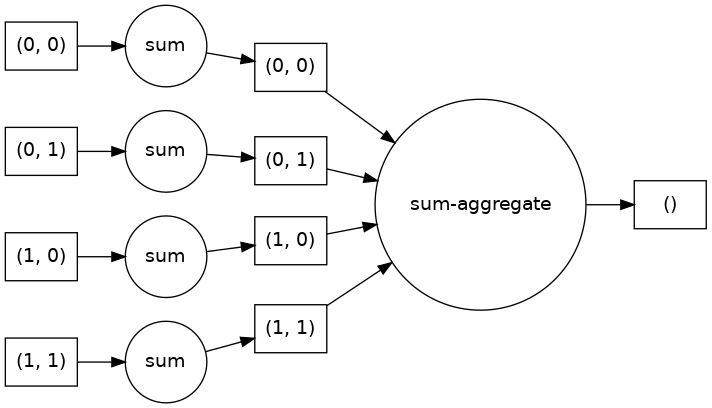

In [4]:
darr.sum().visualize(rankdir="LR")

It is generally good practice to look at the task graph before executing the computation. By looking at the task graph, you can learn about potential bottlenecks where parallelism is not possible. 

<div class="alert alert-block alert-info" markdown="1">

<b>TIP:</b> For big computations, low-level task graphs gets very confusing. An alternative that provides a more concise graph is using `.dask.visualize()`.

</div>


In [5]:
#darr.sum().dask.visualize()


----

Now, let's start with another example. Here we create a 2D array of ones using NumPy.

In [6]:
shape = (10000,12000)

ones_np = np.ones(shape)
ones_np

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

Now, let's create the same array using Dask:

In [21]:
ones_da = da.ones(shape)
ones_da

dask.array<ones_like, shape=(10000, 12000), dtype=float64, chunksize=(2500, 4000), chunktype=numpy.ndarray>

We see a Dask Array representation of the data.
This is a symbolic representation; no data has actually been generated yet. 

As we discussed previously, this mode of operation is called "lazy". 

This allows the user to build up a series of computations or tasks before being passed to the scheduler for execution.

## Chunks

When checking the Dask array, the symbolic representation illustrates the concept of chunks. Dask arrays split the data into **sub-arrays** (or **chunks**) to optimize computation with large arrays.  

### Chunking an array

**The way that arrays are chunked can significantly affect total performance.**

For specifying the chunking of an array, we use the `chunks` argument when creating our `dask.array`.

<div class="alert alert-block alert-warning">

<b>⚠️ WARNING:</b> Please note that `chunks` argument stands for **chunk shape** rather than “number of chunks”.   
For example, `chunks=1` means that you will have several chunks with one element. 
</div>

There are several ways to define `chunks`. For example:

1. A uniform dimension size like 1000, meaning chunks of size 1000 in each dimension. 

2. A uniform chunk shape like `(1000, 2000, 3000)`, meaning chunks of size 1000 in the first axis, 2000 in the second axis, and 3000 in the third. 

3. Fully explicit sizes of all blocks for all dimensions, like `((1000, 1000, 500), (400, 400), (5, 5, 5, 5, 5))`

4. A dictionary specifying chunk size per dimension like `{0: 1000, 1: 2000, 2: 3000}`.


Let's recreate the above Dask array, but this time we will specify chunk sizes (a.k.a. shapes) using the argument `chunks`. 

In [9]:
# -- remember what the shape of our data array was
shape

(10000, 12000)

In [13]:
# create a dask array with 6 chunks
chunk_shape = (5000,4000)
ones_da = da.ones(shape,chunks=chunk_shape)
ones_da

dask.array<ones_like, shape=(10000, 12000), dtype=float64, chunksize=(5000, 4000), chunktype=numpy.ndarray>

You can see in the above dask array representation that we now have 6 chunks, each of shape (5000,4000) and size of ~ 160.0 MiB.

## Performance Comparison

To compare the performance between a NumPy array and an equivalent Dask array, let's calculate the mean. 

In [14]:
%%time
# The %%time cell magic measures the execution time of the whole cell
ones_np.mean()

CPU times: user 80.2 ms, sys: 570 µs, total: 80.8 ms
Wall time: 77.8 ms


1.0

In [24]:
%%time
# Remember, we are not doing any computation here, just constructing our task graph
mean_of_ones_da = ones_da.mean()

CPU times: user 144 µs, sys: 1.07 ms, total: 1.22 ms
Wall time: 1.21 ms


Remember :
> *Dask doesn't do anything until you tell it... It is lazy!*

So far we have just constructed our task graph but no computations yet!

<div class="alert alert-success" markdown="1">

<b>NOTE:</b> In order to generate the data, we need to call the `.compute()` method on the Dask Array to trigger our computation.  

</div>

Let's run the `.compute()` method to see how this works:

In [25]:
%%time
mean_of_ones_da.compute()

CPU times: user 16 ms, sys: 1.01 ms, total: 17 ms
Wall time: 31.4 ms


1.0

`.compute()` method convertes Dask Arrays to Numpy Arrays. Let's check to see if this is true:

In [19]:
type (ones_da.compute())

numpy.ndarray



<div class="alert alert-block alert-warning" markdown="1">

<b>WARNING:</b> Typically, when working with Dask arrays, we do not want to generate the data right away by calling `.compute()` on a large array. 

</div>


We usually want to perform some computations that reduce the data size. For example, we might compute statistics like the mean or standard deviation.

Let's look at an example of taking the mean and visualize the task graph. Remember, that no actual computation is taking place until we call `.compute()`.

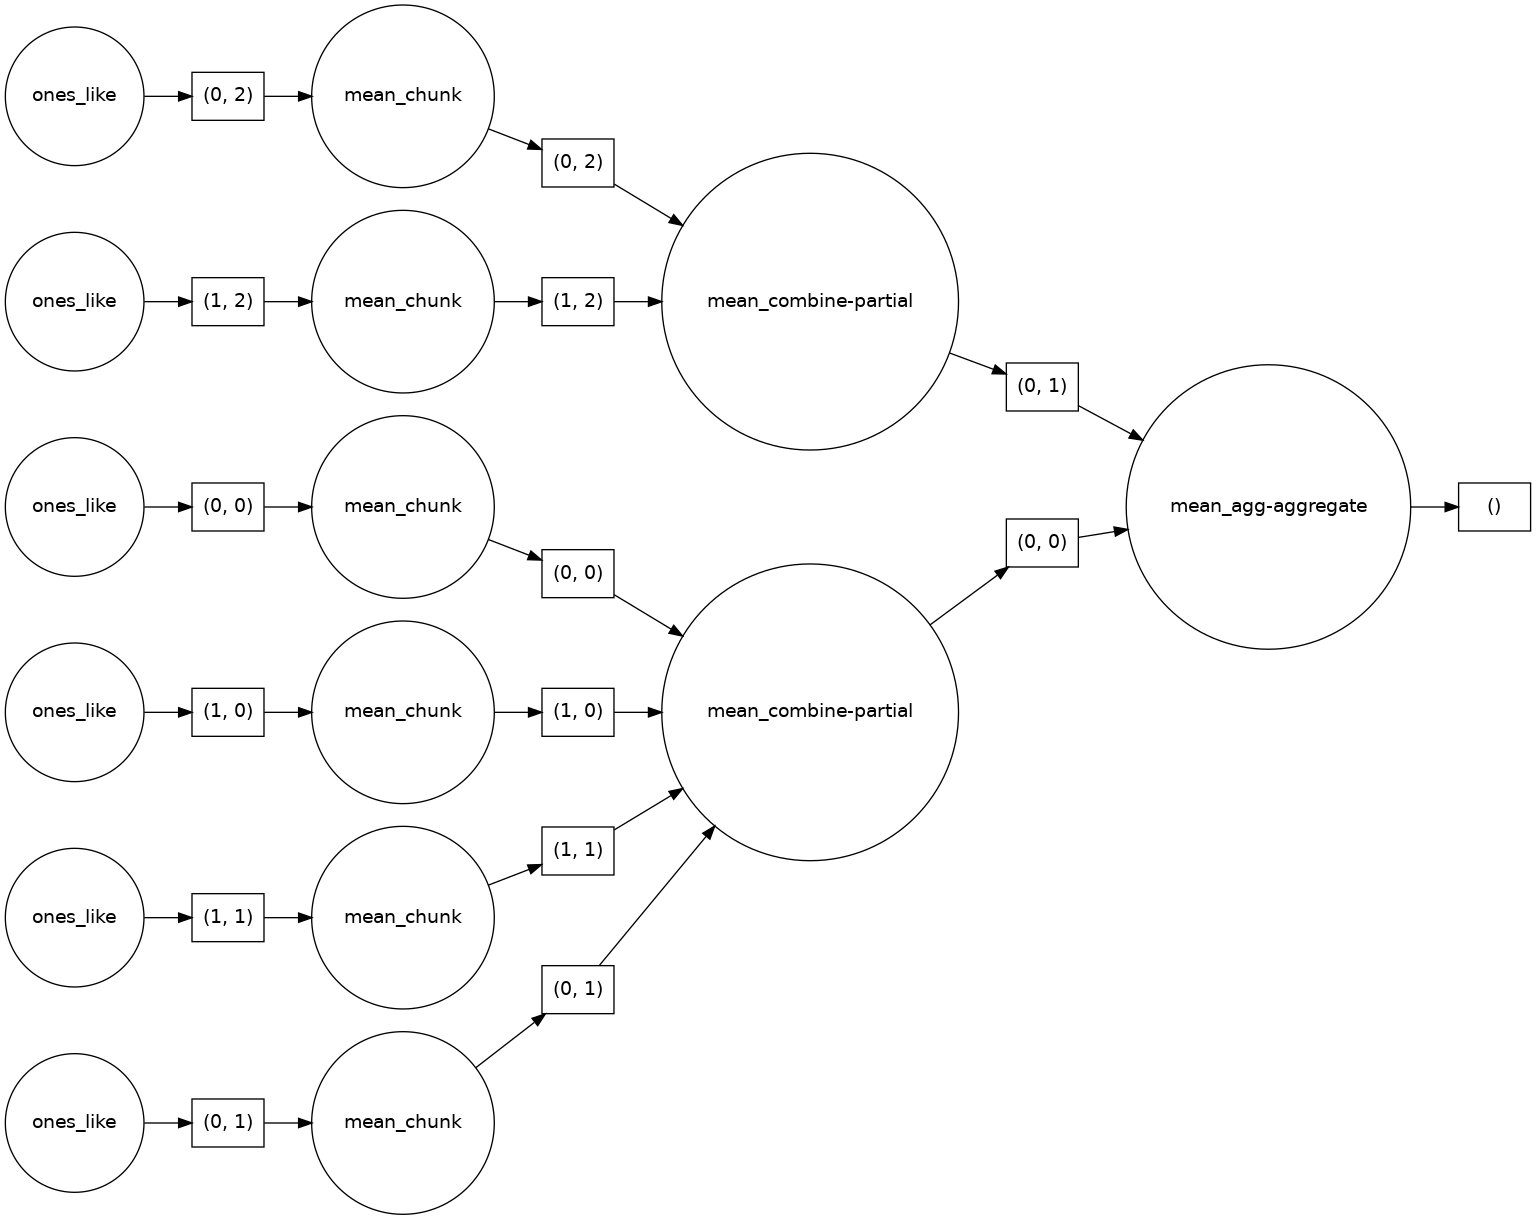

In [20]:
mean_of_ones_da = ones_da.mean()
mean_of_ones_da.visualize(rankdir="LR")

-------


What are the sizes of these arrays in memory?  

First, let's define a function that returns array size in MiB. 

In [26]:
import sys

# Define function to display variable size in MiB
def var_size(in_var):
    result = sys.getsizeof(in_var) / 1024/1024
    return (result)

In [27]:
print("Shape of the numpy array : ", ones_np.shape) 
print("Shape of the dask array  : ", ones_da.shape) 

# memory size of numpy array in MiB
print(f"Memory size of numpy array in MB : {var_size(ones_np):.2f} MiB")
# memory size of dask array in MiB
print(f"Memory size of dask array in MB  : {var_size(ones_da):.2f} MiB")

Shape of the numpy array :  (10000, 12000)
Shape of the dask array  :  (10000, 12000)
Memory size of numpy array in MB : 915.53 MiB
Memory size of dask array in MB  : 0.00 MiB


**Why memory size for the above Dask array is zero?**

Remember, this variable is only a graph representation of the full array which will be split across workers.

However, Dask does give us ways to see the full size of the data (often much larger than your client machine can handle)!

In [28]:
print("Size of Dask dataset:  {:.2f} MiB".format(ones_da.nbytes / 1024/1024))

Size of Dask dataset:  915.53 MiB


## Larger Data
The previous example illustrated how Dask works, but using Dask is not really necessary (nor advisable) for an array of size 915.53 MiB.  
Let's try an example using bigger data and bigger calculations:

In [30]:
big_shape = (2000, 200, 2000)

# -- this will make a big numpy array that might not fit on your machine
#big_np = np.ones(big_shape)

Make a similar Dask Array with similar shape but specifying the `chunks` size:

In [31]:
big_da = da.ones(big_shape)
big_da

dask.array<ones_like, shape=(2000, 200, 2000), dtype=float64, chunksize=(250, 200, 250), chunktype=numpy.ndarray>

In [32]:
# size of data
#print("Memory size of NumPy dataset :  {:.2f} GiB".format(big_np.nbytes / 1024/1024/1024))
print("Memory size of Dask dataset  :  {:.2f} GiB".format(big_da.nbytes / 1024/1024/1024))

Memory size of Dask dataset  :  5.96 GiB


This may be close to the available memory/RAM that you have in your computer.

Let's try bigger calculations on this array:

In [42]:
#%%time 
#z_np = (big_np + big_np.T)[::2,:].mean()

In [43]:
%%time

z_da = (big_da + big_da.T)[::2,:].mean(axis=2)

result = z_da.compute()

CPU times: user 207 ms, sys: 20.3 ms, total: 227 ms
Wall time: 1.16 s


In [47]:
#-- warning : do not try low level visualization with big arrays

#z_da.visualize()

All the usual NumPy functions work on dask arrays, though the computations will remain lazy until you either call `.compute()`, `.load()` or your want to plot the data.

As we discussed above, the way that Dask arrays are chunked can significantly affect the performance. In the remainder of this notebook, let's do a similar calculation using a different `chunks` size. 

We will learn more about best practices regarding `chunk` size later during the tutorial. 


## Supplementary Material: Rechunking Arrays

We can change the chunking of a Dask array, using the `rechunk` method. Please note that rechunking Dask arrays can be very expensive, so choosing an appropriate chunk size initially is ideal.

In [48]:
new_chunk_shape = (50,50,50)
rechunked_big_da = big_da.rechunk(new_chunk_shape)
rechunked_big_da

,Array,Chunk
Bytes,5.96 GiB,0.95 MiB
Shape,"(2000, 200, 2000)","(50, 50, 50)"
Count,12864 Tasks,6400 Chunks
Type,float64,numpy.ndarray


In [49]:
%%time
# perform big computation on chunked array

z_da_rechunked = (rechunked_big_da + rechunked_big_da.T)[::2,:].mean(axis=2)

result = z_da_rechunked.compute()

CPU times: user 10.7 s, sys: 407 ms, total: 11.1 s
Wall time: 14.2 s


We can see how the choice of smaller chunks (more total chunks) **significantly** reduce the total performance of our computation. 

<div class="alert alert-block alert-info" markdown="1">

<b>TIP:</b> As a rule of thumb, a chunk should be big enough so that the computation on that chunk take significantly longer than the overhead from Dask scheduler. The Dask scheduler takes roughly 1ms per task for scheduling. 

</div>

Let's try a bigger chunk size:

In [34]:
new_chunk_shape = (500, 100, 500)
#big_chunk = 

rechunked_big_da = big_da.rechunk(new_chunk_shape)
rechunked_big_da

dask.array<rechunk-merge, shape=(2000, 200, 2000), dtype=float64, chunksize=(500, 100, 500), chunktype=numpy.ndarray>

In [35]:
%%time
# perform big computation on chunked array

z_da_rechunked = (rechunked_big_da + rechunked_big_da.T)[::2,:].mean(axis=2)

result = z_da_rechunked.compute()

CPU times: user 419 ms, sys: 42.6 ms, total: 462 ms
Wall time: 4.38 s



<div class="alert alert-block alert-info" markdown="1">

<b>TIP:</b> As a rule of thumb, a chunk should be small enough to fit comfortably in the memory. Chunk sizes between 10MB-1GB are common, depending on your machine,

</div>


In [36]:
client.close()

## Summary:

* Dask Array provides parallel computing capabilities by dividing arrays into smaller pieces called chunks.
* Blocked algorithms split large computations into smaller computations which operate on subsets of the array.
* Dask Array supports efficient computation on large arrays through a combination of lazy evaluation and task parallelism.
* Dask Array can be used as a drop-in replacement for NumPy ndarray, with a similar API and support for a subset of NumPy functions.
* The way that arrays are chunked can significantly affect total performance. Poor chunking can singifincantly worsen performance of Dask compared to NumPy. 

## Resources and references

* Reference
    *  [Dask Docs](https://dask.org/)
    *  [Dask Examples](https://examples.dask.org/)
    *  [Dask Code](https://github.com/dask/dask/)
    *  [Dask Blog](https://blog.dask.org/)
    
    
    
*  Ask for help
    *   [`dask`](http://stackoverflow.com/questions/tagged/dask) tag on Stack Overflow, for usage questions
    *   [github discussions: dask](https://github.com/dask/dask/discussions) for general, non-bug, discussion, and usage questions
    *   [github issues: dask](https://github.com/dask/dask/issues/new) for bug reports and feature requests
    

* Pieces of this notebook are adapted from the following sources
  * [Dask Performace Comparison](https://tutorial.dask.org/02_array.html#Performance-comparison)
  * [Dask Arrays by EEDS](https://earth-env-data-science.github.io/lectures/dask/dask_arrays.html)